<a href="https://colab.research.google.com/github/Integrall11/Integrall11/blob/main/stroke_clots_(kaggle_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
import cv2 as cv
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model, Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB7

In [ ]:
#change working directory
os.chdir('/content/drive/MyDrive/DeepZoom 754')
os.getcwd()

'/content/drive/MyDrive/DeepZoom 754'

In [ ]:
CE = os.listdir('CE')
LAA = os.listdir('LAA')
print(f'length CE = {len(CE)}; length LAA = {len(LAA)}')

length CE = 547; length LAA = 207


In [ ]:
'''os.mkdir('train')
os.mkdir('test')
os.mkdir('valid')

os.mkdir('train/CE')
os.mkdir('train/LAA')
os.mkdir('test/CE')
os.mkdir('test/LAA')
os.mkdir('valid/CE')
os.mkdir('valid/LAA')'''


os.mkdir('AUG')
os.mkdir('AUG/train')
os.mkdir('AUG/test')
os.mkdir('AUG/valid')

os.mkdir('AUG/train/CE')
os.mkdir('AUG/train/LAA')
os.mkdir('AUG/test/CE')
os.mkdir('AUG/test/LAA')
os.mkdir('AUG/valid/CE')
os.mkdir('AUG/valid/LAA')

In [ ]:
shutil.rmtree('train/CE')
shutil.rmtree('train/LAA')
shutil.rmtree('test/CE')
shutil.rmtree('test/LAA')
shutil.rmtree('valid')
shutil.rmtree('valid')

In [ ]:
#divide data into train-test-valid
for c in ['CE', 'LAA']:
  file_names = os.listdir(c)
  for file in file_names:
    rn = np.random.random()
    src = os.path.join(c, file)
    if rn <= 0.1:
      dist = os.path.join('valid', c, file)
    elif 0.1 < rn <= 0.3:
      dist = os.path.join('test', c, file)
    elif 0.3 < rn:
      dist = os.path.join('train', c, file)
    shutil.copy(src, dist)

In [ ]:
print('train/CE:', len(os.listdir('train/CE')))
print('train/LAA:', len(os.listdir('train/LAA')))
print('test/CE:', len(os.listdir('test/CE')))
print('test/LAA:', len(os.listdir('test/LAA')))
print('valid/CE:', len(os.listdir('valid/CE')))
print('valid/LAA:', len(os.listdir('valid/LAA')))

train/CE: 394
train/LAA: 135
test/CE: 102
test/LAA: 44
valid/CE: 51
valid/LAA: 28


In [ ]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)

AUG image shape = (512, 512, 3)


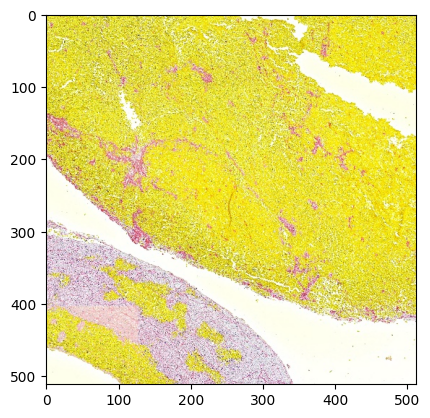

In [ ]:
img = cv.imread('CE/04f7a4_0.jpg').reshape(1, 512, 512, 3)
aug_img = datagen.flow(img).next()[0]
print('AUG image shape =', aug_img.shape)
plt.imshow(aug_img/255.)

In [ ]:
iterations = {'train': 800, 'test': 200, 'valid': 200}
for s in ['train', 'test', 'valid']:
  for c in ['CE', 'LAA']:
    files = os.listdir(os.path.join(s, c))
    i = 0
    while True:
      for f in files:
        path = os.path.join(s, c, f)
        img = cv.imread(path).reshape(1, 512, 512, 3)
        aug_img = datagen.flow(img).next()[0]
        dist = 'AUG/' + s + '/' + c + '/' + f[:-4] + str(i) + '.jpg'
        cv.imwrite(dist, aug_img)
        i += 1
        print(f'{s}; {c}; {i}')
        if i >= iterations[s]:
          print('Break!!!!')
          break
      if i >= iterations[s]:
        print('BREAKKKKK')
        break

In [ ]:
f[:-4]

'098f15_0'

In [ ]:
print('AUG/train/CE:', len(os.listdir('AUG/train/CE')))
print('AUG/train/LAA:', len(os.listdir('AUG/train/LAA')))
print('AUG/test/CE:', len(os.listdir('AUG/test/CE')))
print('AUG/test/LAA:', len(os.listdir('AUG/test/LAA')))
print('AUG/valid/CE:', len(os.listdir('AUG/valid/CE')))
print('AUG/valid/LAA:', len(os.listdir('AUG/valid/LAA')))

AUG/train/CE: 800
AUG/train/LAA: 800
AUG/test/CE: 200
AUG/test/LAA: 200
AUG/valid/CE: 200
AUG/valid/LAA: 200


In [ ]:
#EfficientNetB4

#define data
TARGET_SIZE = (512, 512)
BATCH_SIZE = 32

datagen = ImageDataGenerator(preprocessing_function=None)
test_datagen = ImageDataGenerator(preprocessing_function=None)

train_data = datagen.flow_from_directory('AUG/train',
                                        target_size=TARGET_SIZE, class_mode='binary',
                                        batch_size=BATCH_SIZE, shuffle=True, color_mode='rgb')

valid_data = datagen.flow_from_directory('AUG/valid',
                                        target_size=TARGET_SIZE, class_mode='binary',
                                        batch_size=BATCH_SIZE, shuffle=False, color_mode='rgb')

test_data = test_datagen.flow_from_directory('AUG/test',
                                            target_size=TARGET_SIZE, class_mode=None,
                                            batch_size=BATCH_SIZE, shuffle=False, color_mode='rgb')

base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape= TARGET_SIZE + (3,), pooling='avg')

for layer in base_model.layers:
  if ('block7' not in layer.name) & ('top' not in layer.name):
    layer.trainable = False

x = base_model.output
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(
  loss=keras.mea',
  optimizer=Adam(learning_rate=1e-3),
  metrics=['accuracy', 'AUC']
)

#train the model
EPOCHS = 40
es = EarlyStopping(monitor='val_loss', patience=10, mode='max')
rLR = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='max', min_lr=1e-7)
checkpoint = ModelCheckpoint('/kaggle/working/best.h5', monitor='val_loss', save_best_only=True)
history = model.fit(train_data, epochs=EPOCHS, validation_data=valid_data, callbacks=[es, rLR])

#plot model performance during training
plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'validation'])

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'validation'])

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.legend(['train', 'validation'])

plt.show()

#evaluate the model on test data
test_pred = model.predict(test_data)
test_pred[test_pred <= 0.5] = 0
test_pred[test_pred > 0.5] = 1

acc = accuracy_score(test_data.classes, test_pred)
print(f'acc = {acc}')

print(confusion_matrix(test_data.classes, test_pred))
print(test_data.class_indices)
auc = roc_auc_score(test_data.classes, test_pred)
print(f'AUC = {auc}')


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/40
50/50 [==============================] - 81s 1s/step - loss: 0.5571 - accuracy: 0.7000 - auc: 0.7793 - val_loss: 0.9863 - val_accuracy: 0.4925 - val_auc: 0.5039 - lr: 0.0010
Epoch 2/40
50/50 [==============================] - 54s 1s/step - loss: 0.2432 - accuracy: 0.9025 - auc: 0.9648 - val_loss: 1.5080 - val_accuracy: 0.4975 - val_auc: 0.4885 - lr: 0.0010
Epoch 3/40
50/50 [==============================] - 54s 1s/step - loss: 0.1209 - accuracy: 0.9550 - auc: 0.9914 - val_loss: 2.3927 - val_accuracy: 0.4825 - val_auc: 0.5350 - lr: 0.0010
Epoch 4/40
50/50 [==============================] - 54s 1s/step - loss: 0.0563 - accuracy: 0.9850 - auc: 0.9977 - val_loss: 3.4163 - val_accuracy: 0.5050 - val_auc: 0.4874 - lr: 0.0010
Epoch 5/40
50/50 [==============================] - 54s 1s/step - loss: 0.0629 - accuracy: 0.9781 - auc: 0.9970 - val_loss: 3.7881 - val

In [ ]:
#ResNet50

#define data
TARGET_SIZE = (512, 512)
BATCH_SIZE = 32

datagen = ImageDataGenerator(preprocessing_function=None)
test_datagen = ImageDataGenerator(preprocessing_function=None)

train_data = datagen.flow_from_directory('train',
                                        target_size=TARGET_SIZE, class_mode='binary',
                                        batch_size=BATCH_SIZE, shuffle=True, color_mode='rgb')

valid_data = datagen.flow_from_directory('valid',
                                        target_size=TARGET_SIZE, class_mode='binary',
                                        batch_size=BATCH_SIZE, shuffle=False, color_mode='rgb')

test_data = test_datagen.flow_from_directory('test',
                                            target_size=TARGET_SIZE, class_mode=None,
                                            batch_size=BATCH_SIZE, shuffle=False, color_mode='rgb')

base_model = ResNet50(include_top=False, weights='imagenet', input_shape= TARGET_SIZE + (3,), pooling='avg')

for layer in base_model.layers[:-10]:
  layer.trainable = False

x = base_model.output
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=Adam(learning_rate=1e-3),
  metrics=['accuracy', 'AUC']
)

#train the model
EPOCHS = 40
es = EarlyStopping(monitor='val_loss', patience=10, mode='max')
rLR = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='max', min_lr=1e-7)
checkpoint = ModelCheckpoint('/kaggle/working/best.h5', monitor='val_loss', save_best_only=True)
history = model.fit(train_data, epochs=EPOCHS, validation_data=valid_data, callbacks=[es, rLR])

#plot model performance during training
plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'validation'])

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'validation'])

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.legend(['train', 'validation'])

plt.show()

#evaluate the model on test data
test_pred = model.predict(test_data)
test_pred[test_pred <= 0.5] = 0
test_pred[test_pred > 0.5] = 1

acc = accuracy_score(test_data.classes, test_pred)
print(f'acc = {acc}')

print(confusion_matrix(test_data.classes, test_pred))
print(test_data.class_indices)
auc = roc_auc_score(test_data.classes, test_pred)
print(f'AUC = {auc}')


0.8968824940047961